### Convolutional Variational Encoder for CelebA Face Images

In [35]:
%load_ext watermark
%watermark -v -p torch

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.30.0

torch: 2.3.0



### Imports

In [22]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary

#### Import utility functions

In [23]:
from helper_data import get_dataloaders_celeba
from helper_data import UnNormalize
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_accuracy, plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [24]:
#############
## Settings
#############

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cpu


In [25]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [7]:
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=7dca634b-53b7-4c82-a48e-63a0ec74e383
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:13<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 67.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 23.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 40.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/data/celeba/list_landma

In [8]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

"""Targets are 40-dim vectors representing
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry
11 - Brown_Hair
12 - Bushy_Eyebrows
13 - Chubby
14 - Double_Chin
15 - Eyeglasses
16 - Goatee
17 - Gray_Hair
18 - Heavy_Makeup
19 - High_Cheekbones
20 - Male
21 - Mouth_Slightly_Open
22 - Mustache
23 - Narrow_Eyes
24 - No_Beard
25 - Oval_Face
26 - Pale_Skin
27 - Pointy_Nose
28 - Receding_Hairline
29 - Rosy_Cheeks
30 - Sideburns
31 - Smiling
32 - Straight_Hair
33 - Wavy_Hair
34 - Wearing_Earrings
35 - Wearing_Hat
36 - Wearing_Lipstick
37 - Wearing_Necklace
38 - Wearing_Necktie
39 - Young
"""

Training Set:

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])


'Targets are 40-dim vectors representing\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive\n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry\n11 - Brown_Hair\n12 - Bushy_Eyebrows\n13 - Chubby\n14 - Double_Chin\n15 - Eyeglasses\n16 - Goatee\n17 - Gray_Hair\n18 - Heavy_Makeup\n19 - High_Cheekbones\n20 - Male\n21 - Mouth_Slightly_Open\n22 - Mustache\n23 - Narrow_Eyes\n24 - No_Beard\n25 - Oval_Face\n26 - Pale_Skin\n27 - Pointy_Nose\n28 - Receding_Hairline\n29 - Rosy_Cheeks\n30 - Sideburns\n31 - Smiling\n32 - Straight_Hair\n33 - Wavy_Hair\n34 - Wearing_Earrings\n35 - Wearing_Hat\n36 - Wearing_Lipstick\n37 - Wearing_Necklace\n38 - Wearing_Necktie\n39 - Young\n'

In [9]:
# Number of training, validation, and testing samples
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(valid_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")

# Batch size in loaders
print(f"Training batch size: {train_loader.batch_size}")
print(f"Validation batch size: {valid_loader.batch_size}")
print(f"Testing batch size: {test_loader.batch_size}")


Number of training samples: 162770
Number of validation samples: 19962
Number of testing samples: 19962
Training batch size: 256
Validation batch size: 256
Testing batch size: 256


In [10]:
##########################
### MODEL
##########################

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)

        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded


    def reparameterize(self, z_mu, z_log_var):
        device = z_mu.device
        eps = torch.randn(z_mu.size(0), z_mu.size(1),device = device)
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [11]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

input_size = (3, 128, 128)
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         LeakyReLU-3           [-1, 32, 64, 64]               0
         Dropout2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         LeakyReLU-7           [-1, 64, 32, 32]               0
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          36,864
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
        Dropout2d-12           [-1, 64, 16, 16]               0
           Conv2d-13             [-1, 64, 8, 8]          36,864
      BatchNorm2d-14             [-1, 6

### Training

In [14]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval= 100,
                        save_model='vae_celeba.pt')

Epoch: 001/050 | Batch 0000/0636 | Loss: 709.8308
Epoch: 001/050 | Batch 0100/0636 | Loss: 690.3303
Epoch: 001/050 | Batch 0200/0636 | Loss: 701.2053
Epoch: 001/050 | Batch 0300/0636 | Loss: 719.3959
Epoch: 001/050 | Batch 0400/0636 | Loss: 660.9333
Epoch: 001/050 | Batch 0500/0636 | Loss: 670.1798
Epoch: 001/050 | Batch 0600/0636 | Loss: 660.9744
Time elapsed: 2.79 min
Epoch: 002/050 | Batch 0000/0636 | Loss: 677.7923
Epoch: 002/050 | Batch 0100/0636 | Loss: 665.1403
Epoch: 002/050 | Batch 0200/0636 | Loss: 674.5668
Epoch: 002/050 | Batch 0300/0636 | Loss: 650.2391
Epoch: 002/050 | Batch 0400/0636 | Loss: 652.2195
Epoch: 002/050 | Batch 0500/0636 | Loss: 664.2504
Epoch: 002/050 | Batch 0600/0636 | Loss: 637.3220
Time elapsed: 5.44 min
Epoch: 003/050 | Batch 0000/0636 | Loss: 656.4102
Epoch: 003/050 | Batch 0100/0636 | Loss: 624.1492
Epoch: 003/050 | Batch 0200/0636 | Loss: 660.8337
Epoch: 003/050 | Batch 0300/0636 | Loss: 654.1766
Epoch: 003/050 | Batch 0400/0636 | Loss: 645.4185
Epoc

### Evaluation

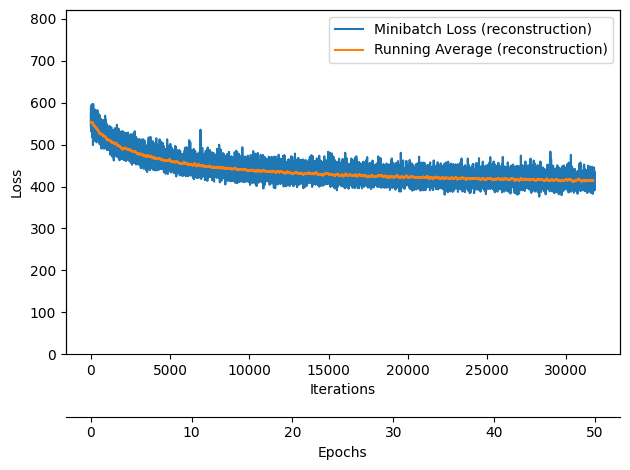

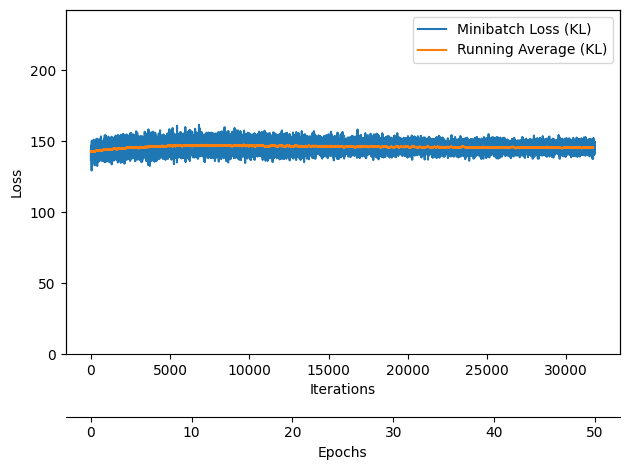

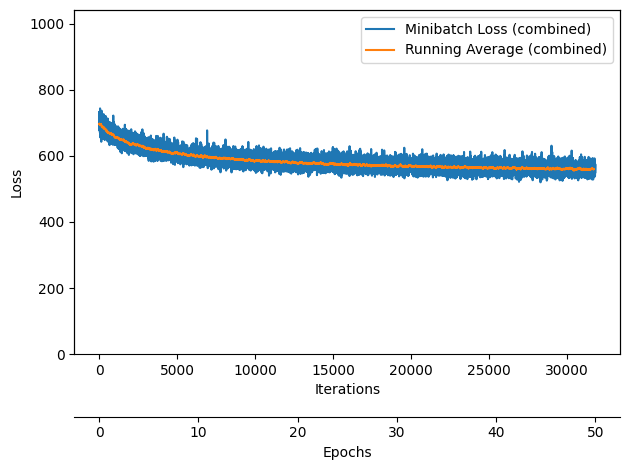

In [15]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

### Plot generated images

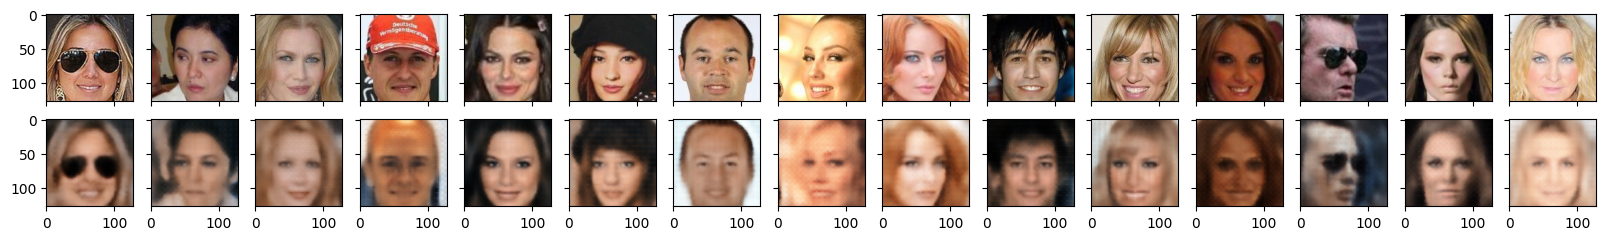

In [16]:
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')

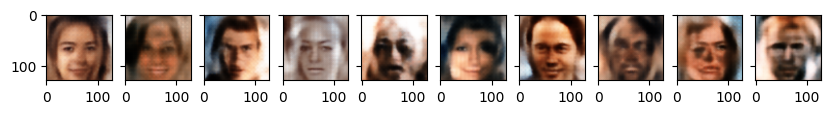

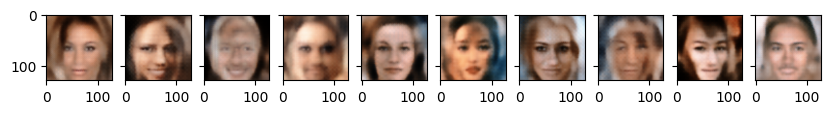

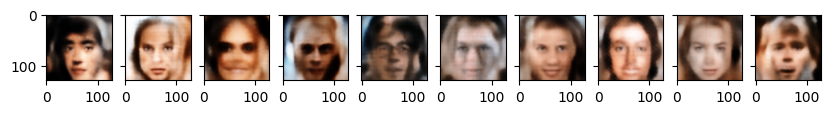

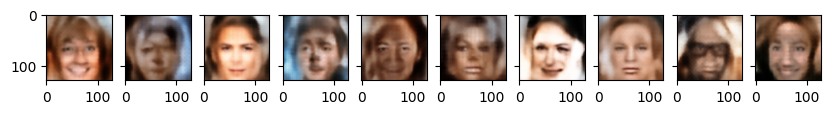

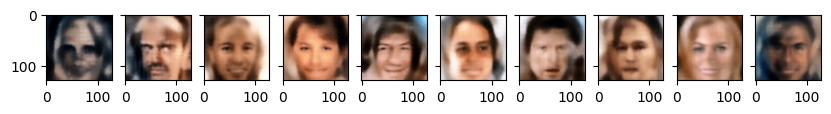

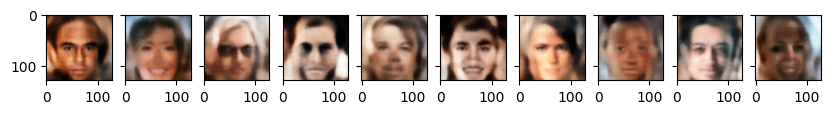

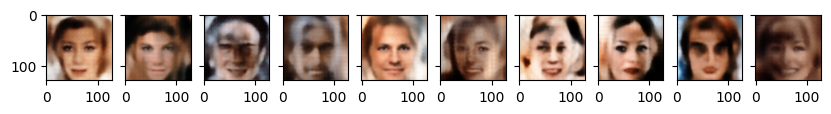

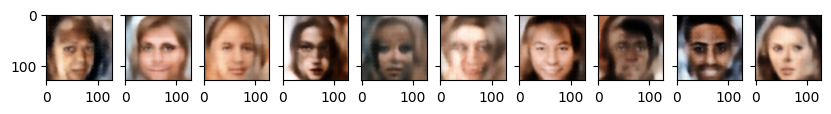

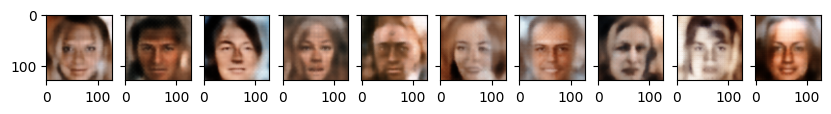

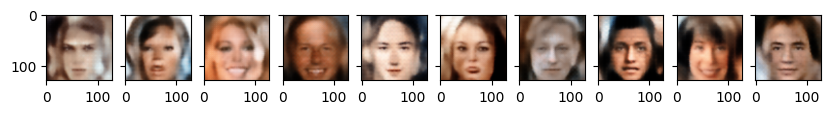

In [17]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=200)
    plt.show()

### Latent space arithmetic

In [5]:
from helper_data import get_dataloaders_celeba
from helper_data import get_dataloaders_celeba_manual_split
from helper_data import compute_average_faces
from helper_plotting import plot_modified_faces

In [15]:
batch_size = 256
train_loader, valid_loader, test_loader = get_dataloaders_celeba_manual_split(
    batch_size=batch_size,
    root='data'
)

In [18]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:



IndexError: list index out of range

### Image manipulation in original space

#### 1) Compute average faces

In [13]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=(3, 128, 128),
    data_loader=train_loader,
    device=None,
    encoding_fn=None)

IndexError: list index out of range

#### Average smiling face

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_with_feat).permute(1, 2, 0))
plt.show()

#### Average non-smiling face

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow((avg_img_without_feat).permute(1, 2, 0))
plt.show()

#### Manipulate example image

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))

ax.imshow(EXAMPLE_IMAGE.permute(1, 2, 0))
plt.show()

In [ ]:
diff = (avg_img_with_feat - avg_img_without_feat)
plot_modified_faces(original=images[1],
                    diff=diff)

plt.tight_layout()
plt.show()

### Image Manipulation in latent space


In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)

        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded


    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

#### Load the model

In [ ]:
model = VAE()
model.load_state_dict(torch.load('vae_celeba_02.pt', map_location=torch.device('cpu')))
model.to(DEVICE);

#### Compute Average Faces in Latent Space -- More or Less Smiling


In [ ]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=31, # smiling
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

In [ ]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()

#### Compute Average Faces in Latent Space -- With or Without Glasses


In [ ]:
avg_img_with_feat, avg_img_without_feat = compute_average_faces(
    feature_idx=15, # eyeglasses
    image_dim=200,
    data_loader=train_loader,
    device=DEVICE,
    encoding_fn=model.encoding_fn)

In [ ]:
diff = (avg_img_with_feat - avg_img_without_feat)

example_img = EXAMPLE_IMAGE.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    encoded = model.encoding_fn(example_img).squeeze(0).to('cpu')

plot_modified_faces(original=encoded,
                    decoding_fn=model.decoder,
                    device=DEVICE,
                    diff=diff)

plt.tight_layout()
plt.show()